In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformación idéntica a entrenamiento
transform = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [4]:
# Backbone
backbone = models.resnet50(pretrained=False)
in_features = backbone.fc.in_features
backbone.fc = nn.Identity()

checkpoint = torch.load("../models/arcface_backbone.pth")
backbone.load_state_dict(checkpoint["backbone"])

# Embedding Layer
embedding_layer = nn.Linear(in_features, 512)
embedding_layer.load_state_dict(checkpoint["embedding"])

# Modo evaluación
backbone = backbone.to(DEVICE).eval()
embedding_layer = embedding_layer.to(DEVICE).eval()

/media/rodfer/Linux/entorno/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/rodfer/Linux/entorno/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
reference_db = np.load("../models/gallery_embeddings.npy", allow_pickle=True).item()
print("Clases en galería:", list(reference_db.keys()))

Clases en galería: ['Abir Ahmed', 'Adriana Sanchez', 'Adriana Solanilla', 'Alejandro Tulipano', 'Amy Olivares', 'Blas de Leon', 'Carlos Beitia', 'Carlos Hernandez', 'Cesar Rodriguez', 'Javier Bustamante', 'Jeremy Sanchez', 'Jonathan Peralta', 'Kevin Rodriguez', 'Mahir Arcia', 'Michael Jordan']


In [6]:
test_dataset = datasets.ImageFolder("../data/preprocessed/train", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

class_names = test_dataset.classes
print("Clases en TRAIN:", class_names)

Clases en TRAIN: ['Abir Ahmed', 'Adriana Sanchez', 'Adriana Solanilla', 'Alejandro Tulipano', 'Amy Olivares', 'Blas de Leon', 'Carlos Beitia', 'Carlos Hernandez', 'Cesar Rodriguez', 'Javier Bustamante', 'Jeremy Sanchez', 'Jonathan Peralta', 'Kevin Rodriguez', 'Mahir Arcia', 'Michael Jordan']


In [7]:
def get_embedding(tensor_img):
    tensor_img = tensor_img.to(DEVICE)
    with torch.no_grad():
        features = backbone(tensor_img)
        emb = embedding_layer(features)
        emb = F.normalize(emb, dim=1)
    return emb.squeeze(0).cpu().numpy()

def recognize_face(embedding, threshold=0.91):
    """
    Compara un embedding facial con una base de datos de embeddings conocidos para identificar el rostro.

    Parámetros:
    ----------
    embedding : numpy.ndarray
        Vector de características (embedding) normalizado que representa la imagen del rostro que se quiere reconocer.
    threshold : float, opcional
        Umbral mínimo de similitud (producto punto) para aceptar una coincidencia como válida.
        Si la similitud máxima es menor a este valor, se considera que el rostro es desconocido.

    Retorno:
    -------
    str
        El nombre de la persona reconocida si la similitud supera el umbral.
        Si no hay ninguna coincidencia suficientemente similar, retorna "Desconocido".
    """
    
    best_match = None
    best_score = -1
    for name, ref_emb in reference_db.items():
        score = np.dot(embedding, ref_emb)
        if score > best_score:
            best_score = score
            best_match = name
    if best_score >= threshold:
        return best_match
    else:
        return "Desconocido"

In [8]:
y_true = []
y_pred = []

for img_tensor, label in test_loader:
    embedding = get_embedding(img_tensor)
    pred_name = recognize_face(embedding, threshold=0.91)
    true_name = class_names[label.item()]
    y_true.append(true_name)
    y_pred.append(pred_name)

print("✅ Evaluación completada.")

✅ Evaluación completada.


In [9]:
# Si alguna predicción es "Desconocido", la incluimos en etiquetas
all_classes = sorted(set(y_true) | set(y_pred))
print("Etiquetas finales:", all_classes)
print(len(all_classes), "clases únicas.")

Etiquetas finales: ['Abir Ahmed', 'Adriana Sanchez', 'Adriana Solanilla', 'Alejandro Tulipano', 'Amy Olivares', 'Blas de Leon', 'Carlos Beitia', 'Carlos Hernandez', 'Cesar Rodriguez', 'Desconocido', 'Javier Bustamante', 'Jeremy Sanchez', 'Jonathan Peralta', 'Kevin Rodriguez', 'Mahir Arcia', 'Michael Jordan']
16 clases únicas.


# Matriz de confusión si normalizar

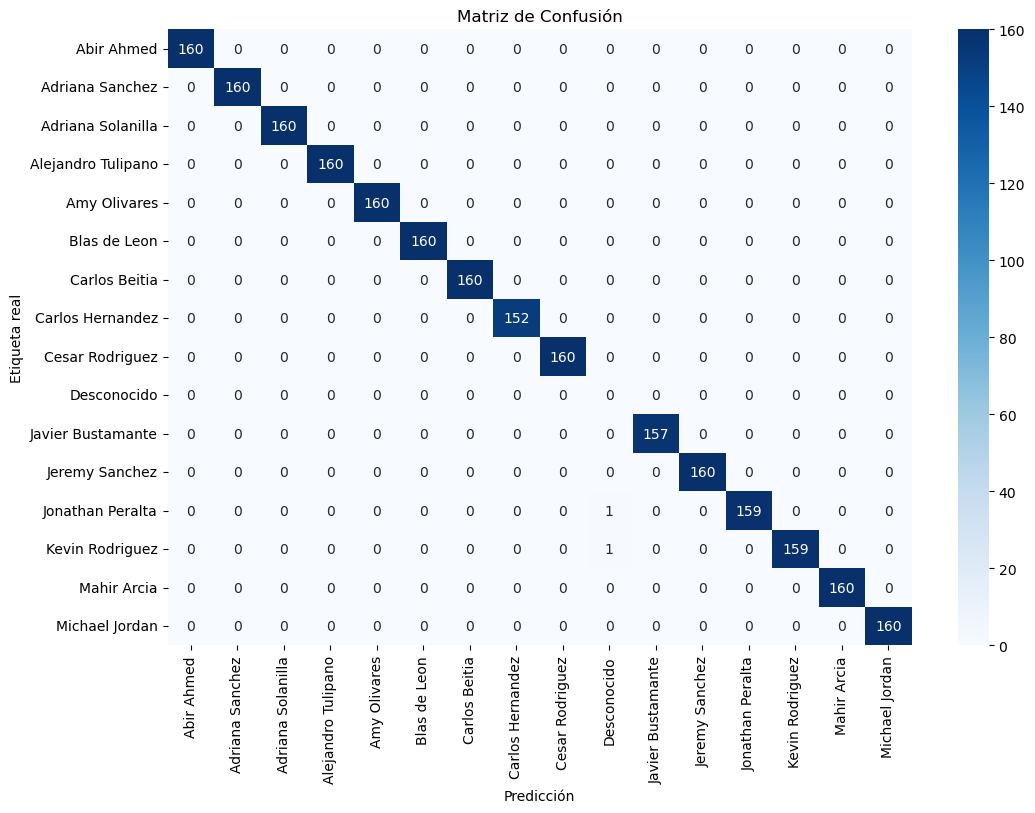

In [18]:
cm = confusion_matrix(y_true, y_pred, labels=all_classes)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=all_classes, yticklabels=all_classes)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.show()

# Matriz de confusión normalizada

/tmp/ipykernel_10630/247810885.py:2: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)


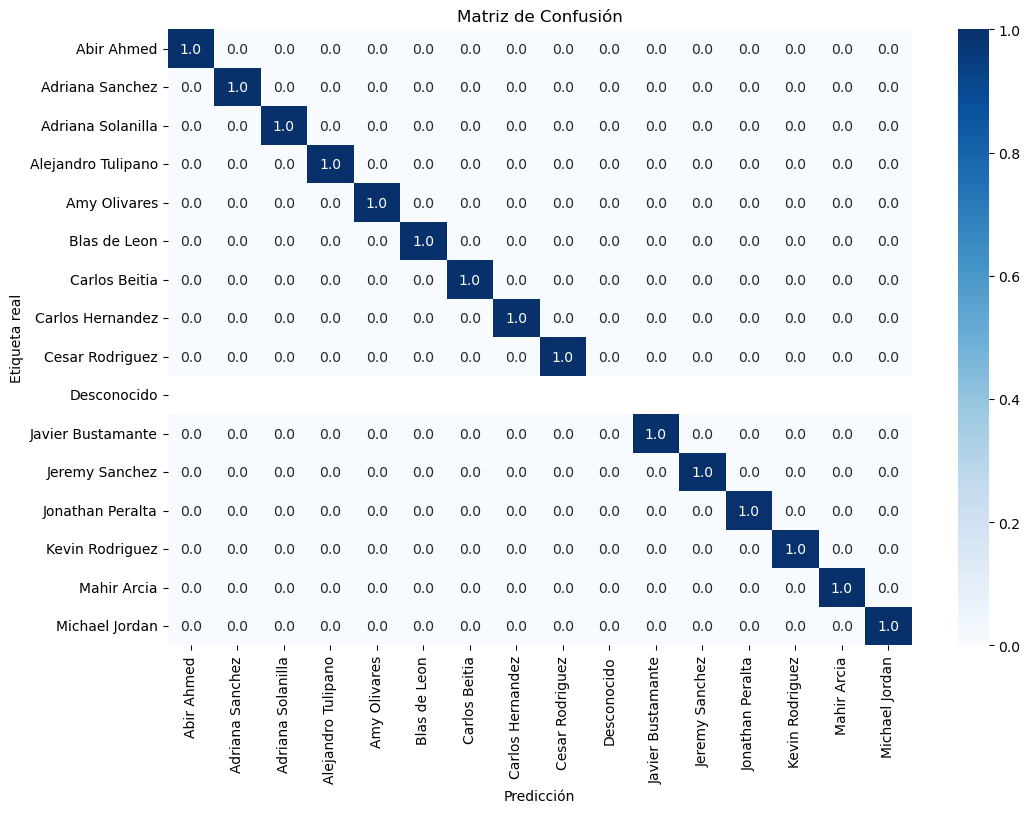

In [19]:
cm = confusion_matrix(y_true, y_pred, labels=all_classes)
cm_normalized = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(12,8))
sns.heatmap(cm_normalized, annot=True, fmt=".1f", cmap="Blues", xticklabels=all_classes, yticklabels=all_classes)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.show()

In [20]:
report = classification_report(y_true, y_pred, labels=all_classes, zero_division=0)
print(report)

                    precision    recall  f1-score   support

        Abir Ahmed       1.00      1.00      1.00       160
   Adriana Sanchez       1.00      1.00      1.00       160
 Adriana Solanilla       1.00      1.00      1.00       160
Alejandro Tulipano       1.00      1.00      1.00       160
      Amy Olivares       1.00      1.00      1.00       160
      Blas de Leon       1.00      1.00      1.00       160
     Carlos Beitia       1.00      1.00      1.00       160
  Carlos Hernandez       1.00      1.00      1.00       152
   Cesar Rodriguez       1.00      1.00      1.00       160
       Desconocido       0.00      0.00      0.00         0
 Javier Bustamante       1.00      1.00      1.00       157
    Jeremy Sanchez       1.00      1.00      1.00       160
  Jonathan Peralta       1.00      0.99      1.00       160
   Kevin Rodriguez       1.00      0.99      1.00       160
       Mahir Arcia       1.00      1.00      1.00       160
    Michael Jordan       1.00      1.00

In [22]:
for t, p in zip(y_true, y_pred):
    if t != p:
        print(f"Real: {t} | Predicho: {p}")

Real: Jonathan Peralta | Predicho: Desconocido
Real: Kevin Rodriguez | Predicho: Desconocido
